In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
import numpy as np
from operator import itemgetter
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

brown_repeats = ['TGGTGG','CCTCCCCT','TGGAG','AGGAG','CCCAG','GGGCT']
inverted_repeats_file = '/data/EBV/repeat_regions/inverted_positions_with_complemented.txt'
file_path = '/data/EBV/byACCIDs/NC_007605.fasta'
mapfile = '/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa_whole_mapping.file'
outpath = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
whole_recom_rate = '/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/whole_10Miters.tsv'
gene_coords_file = '/data/EBV/by_gene/gene_result.txt'

def get_items(d,keylist):
    return itemgetter(*keylist)(d)


def search_fasta(pattern, file_path):
    st = []
    end = []
    pat =[]
    reverse = str(Seq(pattern).reverse_complement())
    
    for patt in [pattern,reverse]:
        for record in SeqIO.parse(open(file_path, "rU"), "fasta"):
            chrom = record.id
            for match in re.finditer(patt, str(record.seq)):
                start_pos = match.start() + 1
                end_pos = match.end() + 1
                st.append(start_pos)
                end.append(end_pos)
                pat.append(patt)
    df = pd.DataFrame({'st':st,'end':end,'pattern':pat,'call':pattern})
    df = df[['st','end','pattern','call']]
    df.sort_values(by=['st'],inplace = True)
    
    return(df)


def compute_local_obs(rrate,r1,r2):
    return(rrate[r1:r2].apply(np.mean))


# requiere map_dict  (reference vs trimed aligment mapping)
# require rrate: dataframe containing stimated recombination rate in whole genome. Its index must be a trimed position. 
# this function require a dataframe indicating regions with two coordinates columns indicating position in reference genome!
# output: tuple (same dataframe plus mapped columns, rho series)
def mapp_and_compute_rho(df,start_col = 'st',end_col = 'end'):
    df = df.dropna(subset=[start_col,end_col])
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x in df[end_col].values]


    df['trimmed_st'] = get_items(mapp_dict,start_aux)
    df['trimmed_end'] = get_items(mapp_dict,end_aux)

    computed_rates = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st,r2 = x.trimmed_end)]),axis =1)
    return df,computed_rates



# this function allow us to extract complete list of features of each desidered region
#repeat_region = complete_features(tipo ='repeat_region' ,n=len(tipo))
#seq_record  must be a Sequence load from a genbank file

def complete_features(seq_record, TIPO='regulatory',n=5 ):
    ttyp = []
    loc = []
    get = []
    pos = []
    for feature in seq_record.features:
        ttyp.append(feature.type)

        if TIPO[0:n] in feature.type:
            get.append({k: feature.qualifiers[k][0] for k in feature.qualifiers.keys()})

            partes = []
            for p in feature.location.parts:
                partes.append(pd.Series([p.start.position,p.end.position]))
            positions = pd.concat(partes,1).transpose()    
            positions.columns = ['start','end']
            pos.append(positions)        #print feature

    get = pd.DataFrame(get)        
    pos = pd.concat(pos)

#    return(get,pos)

    pos.index = get.index
    get_features = pd.concat([get,pos],1)
        
    return(get_features)


def pos_to_trim(p):
    if type(p) in [int,float,numpy.int64] :
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in [p]]
    else:
        tr = [x if x in mapp_dict.keys() else (x -1 ) for x in p]
    return(get_items(mapp_dict,tr))


####### map for all downstream analysis####
###########################################
mapp = pd.read_csv(mapfile,sep = '|')
mapp_dict = mapp[['refCoord','trimmedCoord']]

rrate = pd.read_csv(whole_recom_rate,sep = '|')
rrate.set_index(['trimmed_position'],inplace = True)

mapp_dict =  {}
refcoords = mapp.loc[:,'refCoord']
trimcoords = mapp.loc[:,'trimmedCoord']
for i in range(mapp.shape[0]):
    mapp_dict.update({refcoords[i]:trimcoords[i]})


    
def look_for_gene(position,gene_coords):
    res = gene_coords[(position> gene_coords.start_position_on_the_genomic_accession) & (position<gene_coords.end_position_on_the_genomic_accession)]
    m = res[['Symbol','gen_len']].drop_duplicates()
    m.sort_values(by=['gen_len'],ascending = True)
    if m.shape[0]>0:
        return(m.Symbol[0])
    else:
        return('intr')
    

In [2]:
#df provide start- end positions
def compute_gap(df,start_col='st',end_col='end',window = 200):
    mmax = mapp.refCoord.max()
    col ='Mean Rho/bp.'
    start_aux = [x if x in mapp_dict.keys() else (x +1 ) for x in df[start_col].values]
    end_aux = [x if x in mapp_dict.keys() else (x -1 ) for x  in df[end_col].values]
    trimmed_start = get_items(mapp_dict,start_aux)
    trimmed_end = get_items(mapp_dict,end_aux)

    start_gap = [x-window if x-window in mapp_dict.keys() else (x -window +1 ) for x in df[start_col].values]
    end_gap = [x +window if x+window in mapp_dict.keys() else (x +window -1 ) for x in df[end_col].values]
    end_gap = [x if (x <= mmax) else mmax for x in end_gap]
    
    trimmed_start_gap = get_items(mapp_dict,start_gap)
    trimmed_end_gap = get_items(mapp_dict,end_gap)
    
    
    df['trimmed_st'] = trimmed_start
    df['trimmed_end'] = trimmed_end

    df['trimmed_st_gap'] = trimmed_start_gap
    df['trimmed_end_gap'] = trimmed_end_gap

    rate_prev = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_st_gap,r2 = x.trimmed_st)]),axis =1)
    rate_post = df.apply(lambda x: pd.concat([x,compute_local_obs(rrate,r1 = x.trimmed_end,r2 = x.trimmed_end_gap)]),axis =1)
    
    
    return(pd.merge(rate_prev[[start_col,end_col,'call',col]],rate_post[col].to_frame(),right_index = True,
                    left_index = True,suffixes=['_left','_right']))
    
    #rate_prev[col].fillna(0,inplace = True)
    #rate_post[col].fillna(0,inplace = True)
    #rate_prev['diff'] = rate_prev[col]-rate_post[col]
    #rate_prev['gap_perc'] = (rate_post[col]-rate_prev[col])/np.min([rate_prev[col],rate_post[col]])
    
    #return(rate_prev[[start_col,end_col,'call','']])
    
    #:pos_to_trim(repeat_postions.end[0])]

In [3]:
%matplotlib inline

print 'analyzing Brown motifs'
positions = {}
for br_rep in brown_repeats:
    df = search_fasta(br_rep,file_path)
    positions.update({br_rep:df})
    
repeat_postions = pd.concat(positions)


####### compute gaps (jumps) arround brown motifs
gaps = compute_gap(repeat_postions,window=10)
gaps2 = gaps.copy()
mmin = gaps[['Mean Rho/bp._left','Mean Rho/bp._right']].apply(lambda x: np.nanmin(x)).min()
gaps2['Mean Rho/bp._left'].fillna(mmin,inplace = True)
gaps2['Mean Rho/bp._right'].fillna(mmin,inplace = True)

gaps2['diff'] =gaps2['Mean Rho/bp._right']-gaps2['Mean Rho/bp._left']

gaps2['gap'] =gaps2.apply(lambda x:
                          (x['Mean Rho/bp._right']-x['Mean Rho/bp._left'])/np.min([x['Mean Rho/bp._right'],x['Mean Rho/bp._left']]),1)



analyzing Brown motifs


In [1]:
#gene_coords.Symbol.str.contains('')

In [61]:
gaps2[(gaps2.st>70000)&(gaps2.gap>500)]

st     end    call  Mean Rho/bp._left  Mean Rho/bp._right  \
AGGAG  131   70139   70144   AGGAG           0.000010            0.028361   
       135   73189   73194   AGGAG           0.000010            0.013120   
       592   75437   75442   AGGAG           0.000010            0.006843   
       142   81250   81255   AGGAG           0.000010            0.014620   
       633  101960  101965   AGGAG           0.000010            0.006560   
       634  102323  102328   AGGAG           0.000010            0.059960   
       284  104885  104890   AGGAG           0.000010            0.118560   
       645  111391  111396   AGGAG           0.000010            0.010970   
       647  114608  114613   AGGAG           0.000010            0.014960   
       649  115664  115669   AGGAG           0.000010            0.031319   
       305  116232  116237   AGGAG           0.000010            0.059440   
       651  116311  116316   AGGAG           0.000010            0.015355   
       329  135560  135565   AGGAG           0.000040            0.058205   
       714  156444  156449   AGGAG           0.000010            0.008720   
CCCAG  796   73180   73185   CCCAG           0.000010            0.006565   
       806   77302   77307   CCCAG           0.000010            0.029630   
       808   77398   77403   CCCAG           0.000010            0.029630   
       819   80217   80222   CCCAG           0.000260            0.428735   
       368   86682   86687   CCCAG           0.000010            0.165793   
       373   88384   88389   CCCAG           0.000010            0.015570   
       392   95108   95113   CCCAG           0.000010            0.110210   
       851   98562   98567   CCCAG           0.000010            0.038455   
       856  100766  100771   CCCAG           0.000010            0.128481   
       858  101136  101141   CCCAG           0.000010            0.009760   
       428  105735  105740   CCCAG           0.000010            0.042680   
       868  106966  106971   CCCAG           0.000010            0.009991   
       879  111234  111239   CCCAG           0.000010            0.010970   
       881  111628  111633   CCCAG           0.000010            0.010970   
       883  112484  112489   CCCAG           0.000010            0.010310   
       476  133491  133496   CCCAG           0.000030            0.096511   
...            ...     ...     ...                ...                 ...   
GGGCT  177   85539   85544   GGGCT           0.000010            0.025383   
       183   88114   88119   GGGCT           0.000010            0.042280   
       571  100942  100947   GGGCT           0.000010            0.009765   
       572  101242  101247   GGGCT           0.000010            0.009760   
       577  102976  102981   GGGCT           0.000010            0.059970   
       580  104035  104040   GGGCT           0.000010            0.012150   
       599  112914  112919   GGGCT           0.000010            0.006840   
       225  115643  115648   GGGCT           0.000010            0.005400   
       637  133489  133494   GGGCT           0.000030            0.096511   
       642  136385  136390   GGGCT           0.000140            0.093723   
       682  159281  159286   GGGCT           0.000010            0.008435   
TGGAG  130   75075   75080   TGGAG           0.000010            0.010440   
       131   75081   75086   TGGAG           0.000010            0.010440   
       518   81490   81495   TGGAG           0.000010            0.115819   
       522   82902   82907   TGGAG           0.000020            0.465500   
       553   98670   98675   TGGAG           0.000010            0.052070   
       175   98821   98826   TGGAG           0.000010            0.052070   
       563  102524  102529   TGGAG           0.000010            0.059960   
       565  103016  103021   TGGAG           0.000010            0.059970   
       567  104040  104045   TGGAG           0.000010            0.012150   
       569  

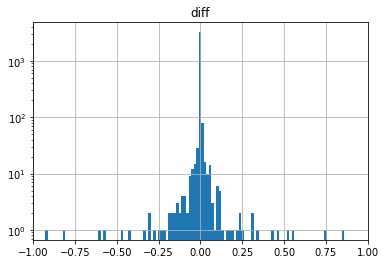

In [4]:
gaps2[['diff']].hist(bins = 500)
plt.xlim([-1,1])
plt.yscale('log')
#plt.xscale('symlog')

In [14]:
### prepare random 5 mers
kmer = 5
rand_gap_windows = 10
np.random.seed(123)
rand = np.random.choice(np.arange(mapp.refCoord.max()-(2*rand_gap_windows+2))+rand_gap_windows,1000,replace=False)
rand.sort()

rand_df = pd.DataFrame({'st':rand,'end':rand+kmer})
rand_df['call'] = 'random'


## get a null hipotesys for those gaps
randgaps = compute_gap(rand_df,window = rand_gap_windows)
randgaps2 = randgaps.copy()
mmin = randgaps[['Mean Rho/bp._left','Mean Rho/bp._right']].apply(lambda x: np.nanmin(x)).min()
randgaps2['Mean Rho/bp._left'].fillna(mmin,inplace = True)
randgaps2['Mean Rho/bp._right'].fillna(mmin,inplace = True)

randgaps2['diff'] =randgaps2['Mean Rho/bp._right']-randgaps2['Mean Rho/bp._left']

randgaps2['gap'] =randgaps2.apply(lambda x:
                          (x['Mean Rho/bp._right']-x['Mean Rho/bp._left'])/np.min([x['Mean Rho/bp._right'],x['Mean Rho/bp._left']]),1)



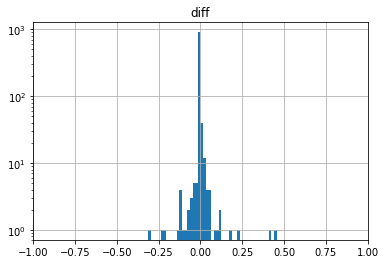

In [15]:
randgaps2[['diff']].hist(bins = 500)

plt.xlim([-1,1])
plt.yscale('log')

In [16]:
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_coords['gen_len']= gene_coords['end_position_on_the_genomic_accession'] - gene_coords['start_position_on_the_genomic_accession']

gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','gen_len']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

gaps3 = gaps2.reset_index()
gen_st =gaps3.st.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))
gen_end =gaps3.end.apply(lambda x:np.unique([look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2'])]))


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
gene_coords_file = '/data/EBV/by_gene/gene_result.txt'
### check orientation
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_coords['gen_len']= gene_coords['end_position_on_the_genomic_accession'] - gene_coords['start_position_on_the_genomic_accession']

gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','gen_len']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

gaps3 = gaps2.reset_index()
#gene =  gaps3.st.apply(lambda x:look_for_gene(position=x,gene_coords=gene_ref_coords[gene_ref_coords.Symbol!='LMP2']))
gene =  gaps3.st.apply(lambda x:look_for_gene(position=x,gene_coords=gene_ref_coords))

gaps3['GENE'] = gene
rep_with_gene = gaps3.copy()

#rep_with_gene.GENE.replace({'intr':'LMP2'},inplace = True)

rep_with_gene_orient = pd.merge(rep_with_gene,gene_coords[['Symbol','orientation']],left_on=['GENE'],right_on='Symbol',how = 'left').drop(['Symbol'],1)
rep_with_gene_plus = rep_with_gene_orient[rep_with_gene_orient.orientation == 'plus']
rep_with_gene_minus = rep_with_gene_orient[rep_with_gene_orient.orientation == 'minus']
rep_with_gene_intron = rep_with_gene_orient[rep_with_gene_orient.orientation.isnull()]
                                   

  

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
right_tresh = randgaps2[['gap']].quantile(0.975)['gap']
left_tresh = randgaps2[['gap']].quantile(0.025)['gap']

  
initiators_PLUS = rep_with_gene_plus[rep_with_gene_plus.gap>right_tresh][['st','end','call','Mean Rho/bp._left','Mean Rho/bp._right','GENE','orientation']]#.value_counts().sort_index()#/rep_with_gene_plus['call'].value_counts()
initiators_MINUS = rep_with_gene_minus[rep_with_gene_minus.gap<left_tresh][['st','end','call','Mean Rho/bp._left','Mean Rho/bp._right','GENE','orientation']]#.value_counts()#/rep_with_gene_plus['call'].value_counts()


print right_tresh
print left_tresh

471.325
-594.85014881


In [50]:
rep_with_gene_plus[rep_with_gene_plus.gap>right_tresh]

,level_0,level_1,st,end,call,Mean Rho/bp._left,Mean Rho/bp._right,diff,gap,GENE,orientation
9,AGGAG,3,1968,1973,AGGAG,0.000010,0.026575,0.026565,2656.500000,BNRF1,plus
28,AGGAG,12,7038,7043,AGGAG,0.000010,3.905290,3.905280,390528.000000,LMP2,plus
723,AGGAG,125,66136,66141,AGGAG,0.000010,0.114364,0.114354,11435.375000,BORF2,plus
725,AGGAG,580,67091,67096,AGGAG,0.000010,0.012469,0.012459,1245.888889,BaRF1,plus
726,AGGAG,580,67091,67096,AGGAG,0.000010,0.012469,0.012459,1245.888889,BaRF1,plus
729,AGGAG,581,67560,67565,AGGAG,0.000020,0.020657,0.020637,1031.833333,LMP2,plus
741,AGGAG,130,69452,69457,AGGAG,0.000010,0.249380,0.249370,24937.000000,BMRF2,plus
742,AGGAG,131,70139,70144,AGGAG,0.000010,0.028361,0.028351,2835.125000,LMP2,plus
771,AGGAG,142,81250,81255,AGGAG,0.000010,0.014620,0.014610,1461.000000,LMP2,plus
962,AGGAG,634,102323,102328,AGGAG,0.000010,0.059960,0.059950,5995.000000,LMP2,plus


In [20]:
print (rep_with_gene_plus.gap>right_tresh).sum()/float(rep_with_gene_plus.shape[0])
print (rep_with_gene_minus.gap<left_tresh).sum()/float(rep_with_gene_minus.shape[0])


0.0121574283948
0.0226196738559


In [127]:
print initiators_MINUS.shape
print initiators_PLUS.shape

(43, 7)
(59, 7)


In [115]:
from scipy import stats
np.random.seed(12345678)
x = stats.norm.rvs(loc=5, scale=3, size=1000)
stats.shapiro(x)

(0.9987979531288147, 0.753572940826416)

In [119]:
stats.shapiro(initiators_PLUS['Mean Rho/bp._right'].values)

(0.6073609590530396, 1.935548804565812e-10)

In [131]:
from scipy.stats  import mannwhitneyu as mwu
from scipy.stats  import ranksums as rks

initiators_MINUS['Mean Rho/bp._left'].mean()
initiators_PLUS['Mean Rho/bp._right'].mean()
x=initiators_MINUS['Mean Rho/bp._left'].values
y=initiators_PLUS['Mean Rho/bp._right'].values
print mwu(x,y)
print stats.ks_2samp(x,y)
import scipy.stats.mstats
print scipy.stats.mstats.ks_twosamp(x,y, alternative='greater')

MannwhitneyuResult(statistic=645.5, pvalue=0.083457069327006361)
Ks_2sampResult(statistic=0.29538266919671097, pvalue=0.055171347956277754)
(0.29538266919671097, 0.034579970676967484)


In [22]:
initiators_MINUS.drop_duplicates(inplace = True)
init_minus_bubble = initiators_MINUS.groupby(['GENE','call'])['Mean Rho/bp._left'].mean().to_frame()
init_minus_bubble.to_csv(outpath+'initiators_minus_wind10.csv')


initiators_PLUS.drop_duplicates(inplace = True)
initiators_PLUS = initiators_PLUS[initiators_PLUS['Mean Rho/bp._right']<1]
init_plus_bubble = initiators_PLUS.groupby(['GENE','call'])['Mean Rho/bp._right'].mean().to_frame()
init_plus_bubble.to_csv(outpath+'initiators_plus_wind10.csv')

In [74]:
df = pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1).apply(lambda x: np.log2(x))
df.sort_values(inplace=True,ascending = False)

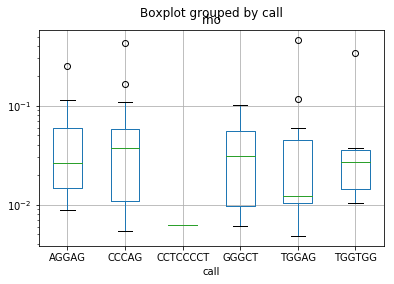

In [105]:
aux2 = pd.concat([initiators_MINUS.rename(columns={'Mean Rho/bp._left':'rho'}),initiators_PLUS.rename(columns={'Mean Rho/bp._right':'rho'})])
aux2.boxplot(by ='call',column='rho')
plt.yscale('log')

In [139]:
motifss = {}
for cat in aux2.call:
    motifss.update({cat:aux2[aux2.call==cat].rho})


In [145]:
motifss.keys()

['CCCAG', 'GGGCT', 'AGGAG', 'CCTCCCCT', 'TGGAG', 'TGGTGG']

In [154]:
v =motifss.values()
scipy.stats.mstats.ks_twosamp(v[0],np.concatenate([v[1],v[2],v[4],v[5]]),alternative='less')

(0.21904761904761902, 0.22474947098289982)

In [94]:
aux = pd.concat([initiators_MINUS[['GENE','call']],initiators_PLUS[['GENE','call']]])
print aux[aux.call=='TGGAG'].GENE.nunique()
print aux[aux.call=='CCCAG'].GENE.nunique()

14
17


In [ ]:
aux[aux.call=='TGGAG'].GENE.nunique()

In [85]:
pd.concat([initiators_MINUS[['GENE','call']], initiators_PLUS.[['GENE','call']]],1)


SyntaxError: invalid syntax (<ipython-input-85-7dd67dae2054>, line 1)

In [83]:
pd.concat([initiators_MINUS.call.value_counts(), initiators_PLUS.call.value_counts()],1).sum(1)
#.apply(lambda x: np.log2(x))

AGGAG       13.0
CCCAG       21.0
CCTCCCCT     1.0
GGGCT       18.0
TGGAG       23.0
TGGTGG       6.0
dtype: float64

In [24]:
import gact
import matplotlib.pyplot as plt
import gact



def draw_logo(score_list):
    fig, ax = plt.subplots(figsize=(5,3))

    all_scores = score_list

    x = 1
    maxi = 0
    for scores in all_scores:
        y = 0
        for base, score in scores:
            gact.letterAt(base, x,y, score, ax)
            y += score
        x += 1
        maxi = max(maxi, y)

    plt.xticks(range(1,x))
    plt.xlim((0, x)) 
    plt.ylim((0, maxi)) 
    plt.tight_layout()      


In [25]:
to_plot = []
for i in range(df.shape[0]):
    r = df.index[i]
    score = ((df.values[i]+1)/float(len(r)))
    motif = []
    for s in r:
        motif.append((s,score))
    to_plot.append(motif)


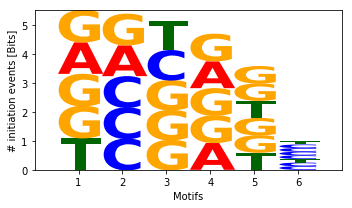

In [26]:
draw_logo(to_plot)

plt.ylabel('# initiation events [Bits]')
plt.xlabel('Motifs')
plt.tight_layout()
#plt.savefig(outpath+'motif_logo'+'.png',dpi = 400)

In [48]:
initiators_PLUS.head()

,st,end,call,Mean Rho/bp._left,Mean Rho/bp._right,GENE,orientation
9,1968,1973,AGGAG,0.00001,0.026575,BNRF1,plus
723,66136,66141,AGGAG,0.00001,0.114364,BORF2,plus
725,67091,67096,AGGAG,0.00001,0.012469,BaRF1,plus
729,67560,67565,AGGAG,0.00002,0.020657,LMP2,plus
741,69452,69457,AGGAG,0.00001,0.249380,BMRF2,plus


In [39]:
motif_gene_dict = {}
for mot in df.index:
    gene_plus = initiators_PLUS[initiators_PLUS.call==mot].GENE
    gene_minus = initiators_MINUS[initiators_MINUS.call==mot].GENE
    motif_gene_dict.update({mot:pd.concat([gene_plus,gene_minus]).unique()})

In [44]:
df.head()

TGGAG     4.523562
CCCAG     4.392317
GGGCT     4.169925
AGGAG     3.700440
TGGTGG    2.584963
dtype: float64

In [42]:
import pickle
with open(outpath+'motif_gene_dict.pickle', 'wb') as handle:
    pickle.dump(motif_gene_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
outpath

'/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/'

## Analize all posible motifs

In [248]:
seq_record = SeqIO.read(genbank_ref_file,'genbank')
seq = seq_record.seq

G = seq.count('G')
C = seq.count('C')
A = seq.count('A')
T = seq.count('T')
l = len(seq_record)-kmer
proba_map = {'G':G/float(l),'C':C/float(l),'A':A/float(l),'T':T/float(l)}


full = pd.DataFrame()
full['st'] =np.arange(len(seq_record)-kmer-gap_windows)+gap_windows
full['end'] = full.st +5
full['call'] = full.apply(lambda x: seq[x.st:x.end],1)
vc = full.call.value_counts()
vc = vc.to_frame().reset_index()
vc.columns = ['motif','counts']
vc['len']=vc.motif.apply(lambda x: len(x))
vc_no_gap = vc[vc.len ==kmer]
vc_no_gap['expected'] = vc_no_gap.motif.apply(lambda x: int(l*np.prod(get_items(d=proba_map,keylist=x))))
vc_no_gap['ratio'] = vc_no_gap.counts/vc_no_gap.expected
vc_no_gap.sort_values(by=['ratio'],ascending = False,inplace = True)
vc_no_gap['mot'] = vc_no_gap.motif.apply(lambda x: str(x))
motif_statistics = vc_no_gap

In [249]:
# browm 5-mer motifs
vc_no_gap[vc_no_gap.mot.isin(df.index)]

,motif,counts,len,expected,ratio,mot
48,"(A, G, G, A, G)",434,5,177,2.451977,AGGAG
10,"(C, C, C, A, G)",573,5,265,2.162264,CCCAG
98,"(T, G, G, A, G)",326,5,185,1.762162,TGGAG
97,"(G, G, G, C, T)",326,5,279,1.168459,GGGCT


In [291]:
#full_ok = full[full.st.isin(mapp_dict.keys())|(full.st+1).isin(mapp_dict.keys()) ]
#                &full.end.isin(mapp_dict.keys())]
ii = (full.st.isin(mapp_dict.keys())|(full.st+1).isin(mapp_dict.keys())) 
ii2 = ((full.st-gap_windows).isin(mapp_dict.keys())|(full.st-gap_windows+1).isin(mapp_dict.keys()))

jj = (full.end.isin(mapp_dict.keys())|(full.end-1).isin(mapp_dict.keys()))
jj2 = ((full.end+gap_windows).isin(mapp_dict.keys())|(full.end+gap_windows-1).isin(mapp_dict.keys()))
full_ok = full[ii&ii2&jj&jj2]
#(~full.end.isin(mapp_dict.keys())).sum()

In [298]:
import time 
t1 = time.clock()
fullgaps = compute_gap(full_ok,window = gap_windows)
t2 = time.clock()
print t2-t1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

4723.423481


In [302]:
### full gaps
fullgaps2 = fullgaps.copy()
mmin = fullgaps[['Mean Rho/bp._left','Mean Rho/bp._right']].apply(lambda x: np.nanmin(x)).min()
fullgaps2['Mean Rho/bp._left'].fillna(mmin,inplace = True)
fullgaps2['Mean Rho/bp._right'].fillna(mmin,inplace = True)

fullgaps2['diff'] =fullgaps2['Mean Rho/bp._right']-randgaps2['Mean Rho/bp._left']

fullgaps2['gap'] =fullgaps2.apply(lambda x:
                          (x['Mean Rho/bp._right']-x['Mean Rho/bp._left'])/np.min([x['Mean Rho/bp._right'],x['Mean Rho/bp._left']]),1)

    

In [307]:
fullgaps2.to_csv(outpath+'fullgaps_by_5mers.csv',index = False)

In [323]:
gene_coords_file = '/data/EBV/by_gene/gene_result.txt'
### check orientation
gene_coords = pd.read_csv(gene_coords_file,sep = '\t')
gene_coords['gen_len']= gene_coords['end_position_on_the_genomic_accession'] - gene_coords['start_position_on_the_genomic_accession']

gene_ref_coords = gene_coords[['GeneID','Symbol','Aliases','start_position_on_the_genomic_accession','end_position_on_the_genomic_accession','gen_len']]
gene_ref_coords['rang'] = gene_coords.apply(lambda x: (x.start_position_on_the_genomic_accession,
                                                   x.end_position_on_the_genomic_accession),1)
gene_ref_coords.set_index(['rang'],inplace = True)

fullgaps3 = fullgaps2.reset_index()
gene =  fullgaps3.st.apply(lambda x:look_for_gene(position=x,gene_coords=gene_ref_coords))

fullgaps3['GENE'] = gene

full_with_gene_orient = pd.merge(fullgaps3,gene_coords[['Symbol','orientation']],left_on=['GENE'],right_on='Symbol',how = 'left').drop(['Symbol'],1)
full_with_gene_orient.drop('index',axis=1,inplace = True)
full_with_gene_orient.drop_duplicates(inplace = True)

full_with_gene_plus = full_with_gene_orient[full_with_gene_orient.orientation == 'plus']
full_with_gene_minus = full_with_gene_orient[full_with_gene_orient.orientation == 'minus']
full_with_gene_intron = full_with_gene_orient[full_with_gene_orient.orientation.isnull()]
#rep_with_gene.GENE.replace({'intr':'LMP2'},inplace = True)
                                   
full_with_gene_orient.to_csv(outpath+'fullgaps_by_5mers_oriented.csv',index = False)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [415]:
peaks_plus = full_with_gene_plus[full_with_gene_plus.gap>right_tresh]
peaks_minus = full_with_gene_minus[full_with_gene_minus.gap<left_tresh]
peaks_intron = full_with_gene_intron[(full_with_gene_intron.gap<left_tresh)|(full_with_gene_intron.gap>right_tresh)]


In [416]:
x = peaks_plus.st
peaks_plus['step'] = [1]+list(x[1::].values-x[:-1].values)
peaks_plus['step'] =  peaks_plus['step']-1
peaks_plus['step'] =  peaks_plus.step.cumsum()
PEAK_PLUS = peaks_plus.loc[peaks_plus.groupby(['step'])['gap'].idxmax(),:]

x = peaks_minus.st
peaks_minus['step'] = [1]+list(x[1::].values-x[:-1].values)
peaks_minus['step'] =  peaks_minus['step']-1
peaks_minus['step'] =  peaks_minus.step.cumsum()
PEAK_MINUS = peaks_minus.loc[peaks_minus.groupby(['step'])['gap'].idxmax(),:]

x = peaks_intron.st
peaks_intron['step'] = [1]+list(x[1::].values-x[:-1].values)
peaks_intron['step'] =  peaks_intron['step']-1
peaks_intron['step'] =  peaks_intron.step.cumsum()
PEAK_INTRON = peaks_intron.loc[peaks_intron.groupby(['step'])['gap'].idxmax(),:]


#full_with_gene_plus[full_with_gene_plus.gapp>right_tresh].head(20)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [580]:
counts = pd.concat([peaks_plus.call.apply(str) ,peaks_minus.call.apply(str),peaks_intron.call.apply(str)]).value_counts()
from Bio.Seq import Seq
rc = [str(Seq(s).reverse_complement()) for s in counts.index]
counts = counts.to_frame()
counts['rc'] =rc
counts['seq'] = counts.index
grouping = pd.merge(counts[['seq','call']],counts[['seq','rc','call']],how = 'left',left_on='seq',right_on='rc').fillna(0)
grouping['calls'] = grouping.call_x+grouping.call_y
grouping.sort_values(by = ['calls'],ascending = False)
grouping.set_index(['seq_x'],inplace = True)

In [698]:
dat = PEAK_PLUS
res = dat.apply(lambda x: {'seq':seq_record[(x.st-15):x.st],'st':x.st},1).tolist()
res = pd.DataFrame(res)


ofile = open(outpath +"plus_all_init.fasta", "w")
for i in range(res.shape[0]):
    x = res.iloc[i]
    ofile.write(">"  +str(x.st) + "\n" +str(x.seq.seq) + "\n")
ofile.close()


In [773]:
aligned = AlignIO.read(outpath+'plus_start_aligned.fa','fasta')
aligned.get_alignment_length()

48

In [788]:
#pd.merge(grouping,vc_no_gap,left_index=True,right_on='mot',how = 'left')

In [775]:
def getKey(item):
    return item[1]


consenso = []
for ix in range(aligned.get_alignment_length()):
    pos = aligned[:,ix]
    lista = []
    for l in ['C','G','A','T']:
        lista.append((l,pos.upper().count(l)))
    consenso.append(sorted(lista,key=getKey))

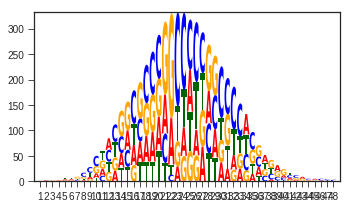

In [776]:
draw_logo(consenso)

In [625]:
from Bio.Align.Applications import ClustalwCommandline
in_file = "unaligned.fasta"
clustalw_cline = ClustalwCommandline("clustalw2",)
#print(clustalw_cline)

In [487]:
grouping.loc['AGGAG']

seq_x     AGGAG
call_x       11
seq_y     CTCCT
call_y        5
calls        16
Name: AGGAG, dtype: object

In [570]:
peaks_plus['strcall'] = peaks_plus.call.apply(str)
peaks_minus['strcall'] = peaks_minus.call.apply(str)
peaks_intron['strcall'] = peaks_intron.call.apply(str)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [564]:
s = 'GGGCT'
P = peaks_plus
alls = P[(P.strcall == s)|(P.strcall == str(Seq(s).reverse_complement()))].st

d = initiators_PLUS
subset = d[d.call == s]
j = subset[~subset.st.isin(alls+1)].st
subset[~subset.st.isin(alls+1)]

,st,end,call,Mean Rho/bp._left,Mean Rho/bp._right,GENE,orientation
3668,6415,6420,GGGCT,0.00001,0.00893,LMP2,plus
4839,112914,112919,GGGCT,0.00001,0.00684,LMP2,plus


### GC For genes

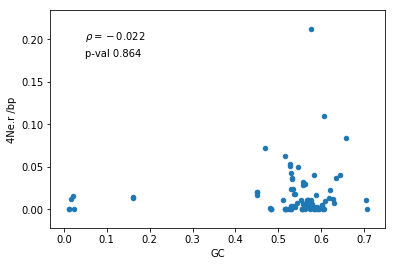

In [490]:
from scipy.stats import spearmanr
gene_gc_nc = pd.read_csv('/home/ariel/Projects/Gutierrez/EBV-recomb/recomb/rdp4_results/ids_171_ebv/10Miter/results/result_by_gene_10Miters.csv_with_ndiv.csv',sep=',')
aux = gene_gc_nc[['Mean.Rho.bp.','GC','NucDiv']].dropna()

sp = spearmanr(aux.GCa.values, aux['Mean.Rho.bp.'])
#spearmanr(aux.NucDiv.values, aux['Mean.Rho.bp.'])


gene_gc_nc.plot(x= 'GC', y = 'Mean.Rho.bp.',kind = 'scatter')

plt.text(x = 0.05, y = 0.2,s=r'$\rho = %s$'%np.round(sp[0],3))
plt.text(x = 0.05,y = 0.18,s='p-val %s'%np.round(sp[1],3))
plt.ylabel('4Ne.r /bp')
plt.savefig(outpath+'GC_vs_rho'+'.png',dpi = 500)

#gene_gc_nc.plot(x= 'NucDiv', y = 'Mean.Rho.bp.',kind = 'scatter')


### Full search of 5,6 and 8 kmer initiating motifs

In [322]:
rep_with_gene_plus[rep_with_gene_plus.gap>right_tresh]['call'].value_counts()/rep_with_gene_plus['call'].value_counts()

In [300]:
genbank_ref_file = '/data/EBV/byACCIDs/genBankRecord_NC_007605.gb'
seq_record = SeqIO.read(genbank_ref_file,'genbank')

In [303]:
gene_coords.orientation.value_counts()

plus     81
minus    69
Name: orientation, dtype: int64

In [432]:
(initiators_PLUS['Mean Rho/bp._right']).sum()

2

In [258]:

def get_rate_by_refefrence_genome(rrate,mapp):
    rrates_reference = pd.merge(mapp[['refCoord','trimmedCoord']],rrate.reset_index(),how='inner',left_on='trimmedCoord',right_on='trimmed_position')
    rrates_reference.head()
    rrates_reference.set_index(['refCoord'],inplace = True)
    rrates_reference.drop(['trimmedCoord','trimmed_position'],1,inplace = True)
    return(rrates_reference)
    
def get_coverage(rrates_reference):
    s = rrates_reference.reset_index().refCoord
    count, division = np.histogram(s,300)
    countbin = [1 if c != 0 else 0 for c in count]
    diff = division[1::]-division[:-1]
    return(np.sum(diff*countbin)/max(division))
    

rate_ref = get_rate_by_refefrence_genome(rrate,mapp)
get_coverage(rate_ref)

0.57999660280327336

In [259]:
rate_ref.head()

,Mean Rho/bp.,-95% CI,+95% CI
refCoord,,,
1,0.00001,0.00001,0.00001
3,0.00001,0.00001,0.00001
8,0.00001,0.00001,0.00001
10,0.00001,0.00001,0.00001
12,0.00001,0.00001,0.00001


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['rand', 'diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


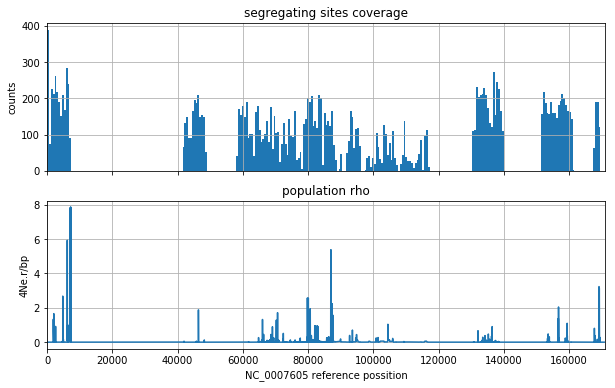

In [493]:


%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(rrates_reference.reset_index().refCoord,bins = 300)
ax1.set_xlim([0,171000])
ax1.set_title('segregating sites coverage')
ax1.set_ylabel('counts')
ax1.grid()

ax2.plot(rrates_reference['Mean Rho/bp.'])
ax2.set_xlabel('NC_0007605 reference possition')
ax2.set_title('population rho')
ax2.set_ylabel('4Ne.r/bp')
ax2.grid()

In [538]:
from Bio import AlignIO
complete = AlignIO.read('/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51.fa','fasta')
aln = AlignIO.read('/data/EBV/msas/ids_171_ebv/ids_171_ebv_msa_gap1.51_trimmed0.05.fas','fasta')

0.594984227496537

In [554]:
lref = 171823
laln = aln.get_alignment_length()
lmapped = mapp.index[-1]
ref_coverage = 1 - (lref-lmapped)/float(lref)
print ref_coverage

print laln/float(lref)

0.965673978455
1.03068273747


In [552]:
mapp.tail()

,refCoord,msaCoord,trimmedCoord
165921,171819,445712,177032
165922,171820,445713,177033
165923,171821,445714,177034
165924,171822,445715,177035
165925,171823,445716,177036


0.57999660280327336

In [525]:
diff[-1]

569.09333333332324

In [521]:
division[-3::]

array([ 169590.81333333,  170159.90666667,  170729.        ])

In [527]:
170729-170159.9

569.1000000000058